# **Lo**w-**R**ank **A**dapater

大模型由于参数量大，微调训练消耗较多资源，这种微调方式称之为全参微调(full-parameter Fintuning)。为了达到高效训练的目的，常见的方式为冻结模型特定层，仅训练特定层，如输出头。

一类高效微调方法是在原模型基础上，附着一个旁路网络，仅微调旁路网络，性能逼近全参微调效果，这一类方法称为参数高效微调(Parameters Efficient FineTunning, PEFT)

LoRA（Low-Rank Adapter） 微调方法，在原模型基础上，增加旁路分支，而分支参数量原小于原模型。例如一个原参数矩阵为 $W\in\mathbb{R}^{d\times d}$ 增加一个网络参数量 $|\theta|<<d\times d$。一个线性层的前向变为 $XW+X\theta$.

本 lecture 按照如下顺序讲解 LoRA：

1. LoRA 原理及推导
2. LoRA 实现
3. 为什么 LoRA 能work? SVD 分解？
4. 原参数梯度矩阵是否有低秩特性？
5. 如何取 Rank？
6. LoRA 的本质与梯度子空间相似性度量
7. LoRA 与 全参微调对比
8. LoRA 微调过程显存分析
9. QLoRA 实现

## 推导

给定线性投影模型:
$$
h=XW
$$
其中, $X\in\mathbb{R}^{N \times d_\text{in}}$, $W\in\mathbb{R}^{d_\text{in} \times d_\text{out}}$, 其梯度为 $\triangle W$ , 模型更新为：
$$
W'=W+\triangle W
$$
此时前向过程为:
$$
h'=XW'=X(W+\triangle W)=XW+X\triangle W
$$
给定最优梯度为$\triangle W^*$
$$
h'=XW'=X(W+\triangle W^*)=XW+X\triangle W^*
$$
将原有的目标求最优:
$$
\arg\min_W \mathcal{L}(W)
$$
转化为求最优梯度，原参数$W$冻结
$$
\arg\min_{\triangle W} \mathcal{L}(W+ \triangle W)
$$
此时将最优梯度参数化为 $\delta\in\mathbb{R}^{d_\text{in}\times d_\text{out}}$
$$
\arg\min_{\delta} \mathcal{L}(W+ \delta)
$$
在优化 $\delta$ 参数量与原模型是一样的，整体网络计算量更大，此时将 $\delta$ 转化为
$$
\delta \rightarrow W_AW_B
$$
其中$W_A\in \mathbb{R}^{d_\text{in}\times r},W_B\in \mathbb{R}^{r \times d_\text{out}}$, $r\ll d$ 为秩, 此时前向计算为
$$
h'=XW'=X(W+\triangle W^*)=XW+\alpha X  W_AW_B
$$
其中$\alpha$为超参数,控制旁路分支强度,优化目标为:
$$
W_A^*,W_B^*=\arg\min_{W_A,W_B} \mathcal{L}(W, W_AW_B)
$$


## 实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

In [2]:
dim = 512
r = 4
bsz = 1
seq_len = 128
vocab_size = 100

x = torch.randint(vocab_size, (bsz, seq_len))
X = torch.randn(bsz, seq_len, dim)

In [3]:
class Attention(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.Wq = nn.Linear(dim_in, dim_out, bias=False)
        self.Wk = nn.Linear(dim_in, dim_out, bias=False)
        self.Wv = nn.Linear(dim_in, dim_out, bias=False)
        self.Wo = nn.Linear(dim_out, dim_out, bias=False)
    def forward(self, X):
        Q, K, V = self.Wq(X), self.Wk(X), self.Wv(X)
        S = Q@K.transpose(1,2)
        P = F.softmax(S, dim = -1)
        Z = P @ V
        O = self.Wo(Z)
        return O

model = Attention(dim, dim)
model(X)
print(model)

Attention(
  (Wq): Linear(in_features=512, out_features=512, bias=False)
  (Wk): Linear(in_features=512, out_features=512, bias=False)
  (Wv): Linear(in_features=512, out_features=512, bias=False)
  (Wo): Linear(in_features=512, out_features=512, bias=False)
)


In [4]:
W = nn.Linear(2,3)
W.in_features

2

In [5]:
class LoRALinear(nn.Module):
    def __init__(self, original_linear, rank=4, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.dim_in = original_linear.in_features
        self.dim_out = original_linear.out_features
        self.r=rank

        # 参数
        self.weight = nn.Parameter(original_linear.weight.data.clone(), requires_grad=False)
        # 处理偏置
        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data.clone(), requires_grad=False)
        else:
            self.register_parameter('bias', None)
        
        self.WA = nn.Linear(self.dim_in, self.r, bias=False)
        self.WB = nn.Linear(self.r, self.dim_out, bias=False)

    def forward(self, X):
        # 出错
        # h = F.linear(x, self.weight, self.bias)

        # 手动
        bsz, seq_len, dim_in = X.shape
        h = X.reshape(bsz*seq_len, dim_in) @ self.weight
        h = h.reshape(bsz, seq_len, self.dim_out)
        if self.bias is not None:
            h += bias.unsqueeze(dim=0).unsqueeze(dim=0)
        
        h_lora = self.alpha * self.WB(self.WA(X))
        return h_lora 

In [6]:
def apply_lora_adapter(model, MyLinear, r):
    """
    更通用的替换函数，支持带偏置的 Linear 层
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            new_layer = MyLinear(module, r)
            setattr(model, name, new_layer)
            print(f"Replaced {name}")
        else:
            # 递归替换
            replace_linear_layers_advanced(module)
    return model

In [7]:
model = Attention(dim, dim)
# print(model)
model = apply_lora_adapter(model, LoRALinear, r=4)
print(model)
H = model(X)
# print(.shape)

Replaced Wq
Replaced Wk
Replaced Wv
Replaced Wo
Attention(
  (Wq): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wk): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wv): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wo): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
)


In [8]:
label = torch.randn(bsz, seq_len, dim)
loss_fn = nn.MSELoss()
loss = loss_fn(H.view(-1), label.view(-1))
print(loss)
loss.backward()

tensor(0.9875, grad_fn=<MseLossBackward0>)


In [9]:
for n, p in model.named_parameters():
    if p.grad is None:
        print(n, 'no_grad')
    else:
        print(n, p.grad.shape)

Wq.weight no_grad
Wq.WA.weight torch.Size([4, 512])
Wq.WB.weight torch.Size([512, 4])
Wk.weight no_grad
Wk.WA.weight torch.Size([4, 512])
Wk.WB.weight torch.Size([512, 4])
Wv.weight no_grad
Wv.WA.weight torch.Size([4, 512])
Wv.WB.weight torch.Size([512, 4])
Wo.weight no_grad
Wo.WA.weight torch.Size([4, 512])
Wo.WB.weight torch.Size([512, 4])


LoRA 对最基础的矩阵参数层添加附加参数，网络中常见 Attention、FFN 模块上也是由多个 Linear 堆叠的。

LoRA 微调的直观感受在于，其目标微调的参数矩阵，遍布模型的各个 block，比单纯去微调一个 LM_head 更加全面

讨论：

1. LoRA 学习了什么？
2. Embedding 层是否可以用 LoRA？
2. LM Head 层是否可以用 LoRA？

## 为什么 LoRA 能 work? SVD 分解？

1. LoRA 散步在模型各个角落
2. 大模型的维度高，有冗余
3. 参数矩阵有低秩性

根据参数近似方法，讨论可行性。
$$
\triangle W \gets W_AW_B
$$

以下代码参考 DeepSeek 生成，不需要细读以下block代码，理解结论即可

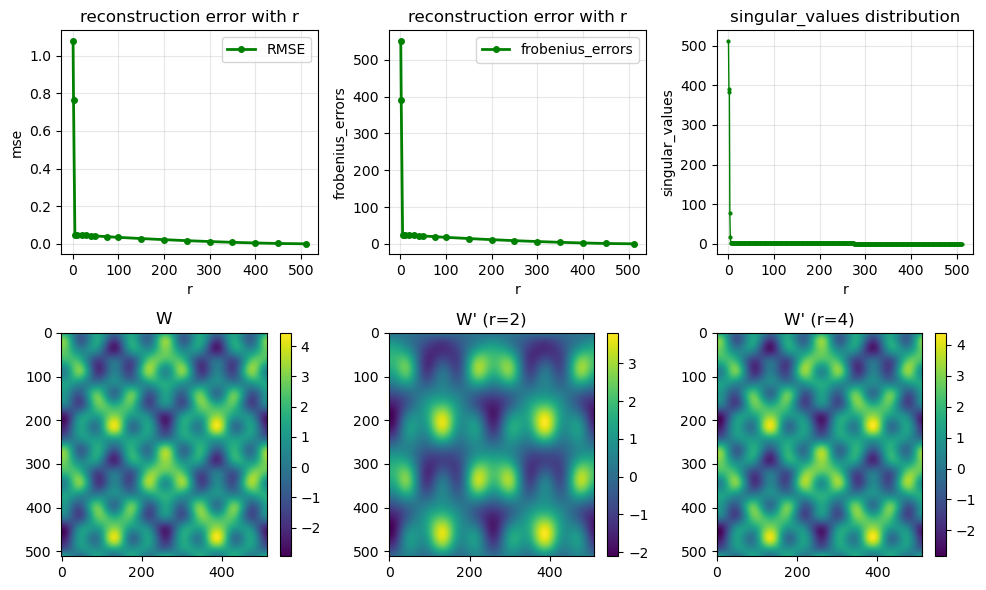

In [10]:
import torch
import matplotlib.pyplot as plt

def generate_test_matrix(size=512, rank=50, random_seed=42):
    """
    创建有规律的数值矩阵
    """
    x = torch.linspace(0, 4 * torch.pi, size)
    y = torch.linspace(0, 4 * torch.pi, size)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    W = (
        2.0 * torch.sin(X) * torch.cos(Y) +           # 基础正弦模式
        1.5 * torch.sin(2 * X + 0.5) * torch.cos(3 * Y - 0.3) +  # 高频模式
        0.8 * torch.exp(-0.01 * (X - 2*torch.pi)**2 - 0.01 * (Y - 2*torch.pi)**2) +  # 高斯脉冲
        0.5 * (X / (4*torch.pi)) * (Y / (4*torch.pi)) +          # 线性梯度
        0.3 * torch.sin(5 * X) * torch.cos(2 * Y)                # 另一个高频模式
    )
    noise = torch.randn(size, size) * 0.05
    W = W + noise
    return W


def svd_reconstruction(W, r):
    """
    使用PyTorch进行SVD分解并用前r个奇异值重构矩阵
    """
    U, s, Vt = torch.svd(W)
    U_r = U[:, :r]
    s_r = s[:r]
    Vt_r = Vt[:, :r] 
    W_reconstructed = U_r @ torch.diag(s_r) @ Vt_r.t()
    return W_reconstructed, s

def calculate_errors(W, W_reconstructed):
    """
    计算各种误差度量
    """
    # Frobenius范数误差
    frobenius_error = torch.norm(W - W_reconstructed, p='fro')
    # 均方根误差 (RMSE)
    rmse = torch.sqrt(torch.mean((W - W_reconstructed)**2))
    return {
        'frobenius': frobenius_error.item(),
        'rmse': rmse.item(),
    }

def plot_results(results, singular_values, W, W_reconstructed_final):
    """
    绘制结果图表
    """
    ranks = list(results.keys())
    
    # 创建子图
    fig = plt.figure(figsize=(10, 6))
    
    # 1. 各种误差随秩的变化
    ax1 = plt.subplot(2, 3, 1)
    rmse_errors = [results[r]['rmse'] for r in ranks]
    ax1.plot(ranks, rmse_errors, 'g-o', linewidth=2, markersize=4, label='RMSE')
    
    ax1.set_xlabel('r')
    ax1.set_ylabel('mse')
    ax1.set_title('reconstruction error with r')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = plt.subplot(2, 3, 2)
    frobenius_errors = [results[r]['frobenius'] for r in ranks]
    ax2.plot(ranks, frobenius_errors, 'g-o', linewidth=2, markersize=4, label='frobenius_errors')
    ax2.set_xlabel('r')
    ax2.set_ylabel('frobenius_errors')
    ax2.set_title('reconstruction error with r')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2. 奇异值分布
    ax3 = plt.subplot(2, 3, 3)
    l=len(singular_values)
    idx=torch.arange(l).tolist()
    ax3.plot(idx, singular_values, 'g-o', linewidth=1, markersize=2, label='singular_values')
    ax3.set_xlabel('r')
    ax3.set_ylabel('singular_values')
    ax3.set_title('singular_values distribution')
    ax3.grid(True, alpha=0.3)
    
    
    # 4. 原矩阵的热图
    ax4 = plt.subplot(2, 3, 4)
    im1 = ax4.imshow(W.cpu().numpy(), cmap='viridis', aspect='auto')
    ax4.set_title('W')
    plt.colorbar(im1, ax=ax4)
    
    # 5. 重构矩阵的热图（使用最大秩）
    ax5 = plt.subplot(2, 3, 5)
    W_reconstructed_final, _ = svd_reconstruction(W, r=2)
    im2 = ax5.imshow(W_reconstructed_final.cpu().numpy(), cmap='viridis', aspect='auto')
    ax5.set_title(f'W\' (r=2)')
    plt.colorbar(im2, ax=ax5)
    
    # 6. 重构矩阵的热图（使用最大秩）
    ax5 = plt.subplot(2, 3, 6)
    W_reconstructed_final, _ = svd_reconstruction(W, r=4)
    im3 = ax5.imshow(W_reconstructed_final.cpu().numpy(), cmap='viridis', aspect='auto')
    ax5.set_title(f'W\' (r=4)')
    plt.colorbar(im3, ax=ax5)
    
    # # 6. 误差矩阵的热图
    # ax6 = plt.subplot(2, 3, 6)
    # error_matrix = torch.abs(W - W_reconstructed_final)
    # im3 = ax6.imshow(error_matrix.cpu().numpy(), cmap='hot', aspect='auto')
    # ax6.set_title('|W - W\'|')
    # plt.colorbar(im3, ax=ax6)
    
    plt.tight_layout()
    plt.show()
    
    return 

def main():
    W = generate_test_matrix(size=512, rank=50, random_seed=42)
    test_ranks = [1, 2, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 512]
    results = {}
    singular_values = None
    for i, r in enumerate(test_ranks):
        W_reconstructed, s = svd_reconstruction(W, r)
        if singular_values is None:
            singular_values = s
        errors = calculate_errors(W, W_reconstructed)
        results[r] = errors
        if r == test_ranks[-1]:
            W_reconstructed_final = W_reconstructed
    
    # 绘制结果
    W_reconstructed_final,_ = svd_reconstruction(W, r=2)
    explained_variance = plot_results(results, singular_values, W, W_reconstructed_final)
    
main()

- 图4 W: 原矩阵 512x512
- 图5 W': SVD分解后, rank=2 重建
- 图5 W': SVD分解后, rank=4 重建 # rank 非常低就能复原原矩阵
- 图1/图2: 随 rank 递增，重建后的误差 RMSE、Norm指标,
- 图3 为原矩阵的特征值, 前4维的特征值显著更大。

用低秩分解的矩阵能够近似原矩阵，并且普遍有 $r\ll d$ 的关系

## 原参数梯度矩阵是否有低秩特性？

上述推导结论为：

$$
\triangle W \gets W_AW_B
$$

1. 我们要分析常规模型求梯度时 $\triangle W$ 的低秩性

In [11]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = Attention(dim, dim)
X=torch.randn(1,16,dim)
label = torch.randn_like(X)

# 假定此模型经过充分的预训练
s_list=[]
s_steps = [0, 10, 100, 1000]
for i in range(1001):
    Y = model(X)
    loss=loss_fn(Y,label)
    loss.backward()
    if i in s_steps:
        data = model.Wv.weight.grad
        _, s = svd_reconstruction(data, 2)
        s_list.append(s)
    optimizer.step()
    optimizer.zero_grad()

4


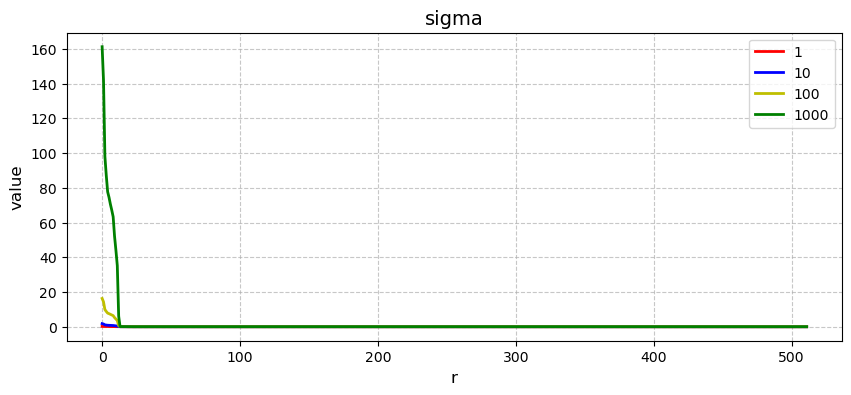

In [12]:
plt.figure(figsize=(10, 4))
print(len(s_list))
i = 10
color = ['r','b','y','g']
for k, s in enumerate(s_list):
    x = torch.arange(dim).tolist()
    y = s.tolist()
    plt.plot(x, y, f'{color[k]}', linewidth=2, label=f'{10**k}')

# 设置标题和标签
plt.title('sigma', fontsize=14)
plt.xlabel('r', fontsize=12)
plt.ylabel('value', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

越充分训练模型, 其梯度的低秩性会越强( $\Sigma$ 前几个数据值很大)

## 如何取 Rank？

1. 在 LoRA 原论文中，R = 1 仍能训练出效果
2. R 当增长到一定程度，其性能收敛，随着r增加，性能表现平稳

## LoRA 初始化

为了避免LoRA参数原模型输出，需要使得 LoRA 旁路分支为 0, 须对 $XW_AW_B$初次前向为零

1. WA为零，WB不为零
2. WA不为零，WB为零
3. WA为零，WB为零：是否有梯度？
4. WA不为零，WB不为零，不满足要求

以上 1,2,3 初始化方法均能达到旁路输出为0的效果，先实现 1, 再分析不同方式初始化对梯度的影响

In [13]:
## LoRA 初始化

class LoRALinear(nn.Module):
    def __init__(self, original_linear, rank=4, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.dim_in = original_linear.in_features
        self.dim_out = original_linear.out_features
        self.r=rank

        # 参数
        self.weight = nn.Parameter(original_linear.weight.data.clone(), requires_grad=False)
        # 处理偏置
        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data.clone(), requires_grad=False)
        else:
            self.register_parameter('bias', None)
        
        self.WA = nn.Linear(self.dim_in, self.r, bias=False)
        self.WB = nn.Linear(self.r, self.dim_out, bias=False)

        nn.init.constant_(self.WA.weight.data, 0.0)
        nn.init.constant_(self.WA.weight.data, 0.0)

    def forward(self, X):
        # 出错
        # h = F.linear(x, self.weight, self.bias)

        # 手动
        bsz, seq_len, dim_in = X.shape
        h = X.reshape(bsz*seq_len, dim_in) @ self.weight
        h = h.reshape(bsz, seq_len, self.dim_out)
        if self.bias is not None:
            h += bias
        
        h_lora = self.alpha * self.WB(self.WA(X))
        return h_lora 

    def _init_weights(self, module):
        """自定义权重初始化"""
        # 默认初始化
        if isinstance(module, (nn.Linear)):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()
        
        # 特殊初始化规则
        for name, p in module.named_parameters():
            # 对WA矩阵进行零初始化
            if name == "WA.weight":
                nn.init.constant_(p, 0.0)
                print(f"Zero initialized {name}")
            
            # 对WB矩阵进行小方差初始化
            elif name == "WB.weight":
                nn.init.normal_(p, mean=0.0, std=0.01)  # 小方差
                print(f"Small variance initialized {name}")

In [14]:
model = Attention(dim, dim)
# print(model)
model = apply_lora_adapter(model, LoRALinear, r=4)
print(model)
H = model(X)
# print(.shape)
print(model.Wq.WA.weight)
print(model.Wq.WB.weight)

Replaced Wq
Replaced Wk
Replaced Wv
Replaced Wo
Attention(
  (Wq): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wk): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wv): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
  (Wo): LoRALinear(
    (WA): Linear(in_features=512, out_features=4, bias=False)
    (WB): Linear(in_features=4, out_features=512, bias=False)
  )
)
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.1336, -0.0119,  0.0179, -0.3497],
        [ 0.2779, -0.1956,  0.2793, -0.1871],
        [ 0.2289, -0.0924, -0.

## 手撕 LoRA 梯度

给定 X(2,4), WA(4,3), WB(3,4), 采用视频课讲述的 “234梯度推导法” 手写反向

In [15]:
X = torch.randn(2,4)
label = torch.randn(2,4)

In [16]:
# case: WA=0, WB=0
WA = torch.zeros(4,3)
WB = torch.zeros(3,4)
YA = X @ WA # -> 2,3
Y = YA @ WB # -> 2,4
dy = 2*(label-Y) // Y.numel() # 2,4

dWB = YA.t() @ dy
dYA = dy @ WB.t()
dWA = X.t() @ dYA
print(dWA)
print(dWB)
# 更新后 WA 和 WB 都不为0
WA_ = WA+dWA
WB_ = WB+dWB
print(WA_)
print(WB_)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


结论1: 全零初始化，没有梯度

In [17]:
# case 1: WA = 0
WA = torch.zeros(4,3)
WB = torch.randn(3,4)

YA = X @ WA # -> 2,3
Y = YA @ WB # -> 2,4
dy = 2*(label-Y) // Y.numel() # 2,4

dWB = YA.t() @ dy
dYA = dy @ WB.t()
dWA = X.t() @ dYA
print(dWA)
print(dWB)
# 更新后 WA 和 WB 都不为0
WA_ = WA+dWA
WB_ = WB+dWB
print(WA_)
print(WB_)

tensor([[-0.3419,  0.0264,  0.1467],
        [-0.5218,  0.0403,  0.2239],
        [-0.5134,  0.0396,  0.2203],
        [-0.1493,  0.0115,  0.0641]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[-0.3419,  0.0264,  0.1467],
        [-0.5218,  0.0403,  0.2239],
        [-0.5134,  0.0396,  0.2203],
        [-0.1493,  0.0115,  0.0641]])
tensor([[ 0.2240, -1.1335,  0.1551, -0.4077],
        [ 0.2219, -0.7207, -0.2511, -0.3188],
        [-1.3724, -0.9826,  1.2097,  0.0464]])


In [18]:
# case 2: WB = 0
WA = torch.randn(4,3)
WB = torch.zeros(3,4)

YA = X @ WA # -> 2,3
Y = YA @ WB # -> 2,4
dy = 2*(label-Y) // Y.numel() # 2,4

dWB = YA.t() @ dy
dYA = dy @ WB.t()
dWA = X.t() @ dYA
print(dWA)
print(dWB)
# 更新后 WA 和 WB 都不为0
WA_ = WA+dWA
WB_ = WB+dWB
print(WA_)
print(WB_)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.6778,  0.0000,  0.6778,  0.0000],
        [-0.0783,  0.0000, -0.0783,  0.0000],
        [-0.2514,  0.0000, -0.2514,  0.0000]])
tensor([[ 1.3130, -0.4247,  0.4755],
        [-1.1841, -0.7320, -0.6246],
        [-0.4331,  0.5660,  0.3482],
        [ 0.8994,  1.7829,  0.5349]])
tensor([[ 0.6778,  0.0000,  0.6778,  0.0000],
        [-0.0783,  0.0000, -0.0783,  0.0000],
        [-0.2514,  0.0000, -0.2514,  0.0000]])


结论2: WA 和 WB 要其中一个矩阵不为 0

In [19]:
# 讨论以下两种 case 哪个更合理
# case 1: WA = 0
# case 2: WB = 0

# WA=0
WA = torch.zeros(4,3)
WB = torch.randn(3,4)
YA = X @ WA # -> 2,3
Y = YA @ WB # -> 2,4
print(YA, )

# WB=0
WA = torch.randn(4,3)
WB = torch.zeros(3,4)
YA = X @ WA # -> 2,3
Y = YA @ WB # -> 2,4
print(YA, )

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[ 0.3476, -3.7929, -2.4141],
        [-0.6591, -2.2827, -0.5009]])


结论3：WB=0 的话, 对于矩阵 WB 来说其输入不为零，更容易学习。

## LoRA Merge

在部署模型时，可以将 LoRA 参数融合到原模型中，减少 forward 的 latency

In [20]:
W = torch.randn(4,4)
WA = torch.randn(4,3)
WB = torch.randn(3,4)

W = W + WA@WB

## LoRA 梯度子空间相似性度量及结论

LoRA 原论文度量：

1. 梯度的低秩性
2. 原参数矩阵的低秩性

验证代码待定

结论: 

1. 原 LLM 模型参数具有低秩性
2. 计算模型 $YA=XWA$ 中，$WA$ 学习特征的低秩表达, 此表达也是成功的
3. 根据1的结论，MLA 更进一步从预训练任务中，降维矩阵学习：词在context中的“低秩”表达。

## LoRA 与 全参微调对比

1. 将 LoRA 参数看成是 全参参数的一个 受限子空间，LoRA 能保留原模型结构
2. LoRA 适用于差数据集微调，对模型调整少，遗忘少
3. 全参对好数据效果好，参数搜索空间大；缺点是易遗忘，掉点严重

另外：LoRA 的 epochs 比 全参微调的多。

## LoRA 微调过程显存分析

相较全参，LoRA 训练显存：

1. 梯度：显著减少，仅保留 LoRA 参数
2. 优化器参数：显著减少，仅保留 LoRA 参数
3. 参数：增加旁路
4. 激活值：增加旁路网络，中间值更多

关于 4 的讨论通常被忽略，可以对旁路分支通过 “gradient checkpoint” 重计算方式减少显存量

## 讨论

1. WAWB 有没有更优的初始化方式？
2. 给定两层线性层，每层线性层都加 LORA， 绘制梯度流
3. LoRA 是否会加速训练
4. 讨论 LoRA、MLA、Muon 三者之间参数的低秩性区别*
5. 为什么主流厂商、研究论文普遍使用 全参微调 而非 PEFT 类方法
6. 如何在 16GB 显卡上微调一个 7B 的模型？
7. QLoRA 原理是什么？分析 LoRA、QLoRA、全参微调方法的耗时、显存、精度之间的差异